# Group 15: 50_Startups

## Members that contributed:

### Dylan McMaster
### Student Number: 578674

### Kyle McAdam
### Student Number: 578403

# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('./50_Startups.csv')

# Exploring

In [3]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
df.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

**Check for missing values**

In [5]:
df.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

**Check correlation of features against label**

Text(0.5, 1.0, 'Correlation between features and target column')

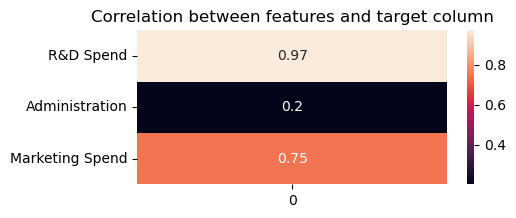

In [6]:
X = df.drop('Profit', axis =1)
y = df['Profit']
fig, ax = plt.subplots(figsize=(5,2))
corr_matrix = X.corrwith(y)

sns.heatmap(corr_matrix.to_frame(), annot=True)
plt.title('Correlation between features and target column')


Looks like the administration column has a very low correlation with the target column compared to the other two. This may imply that administration has little contribution to the prediction of profit.

**Check correlation between all the features**

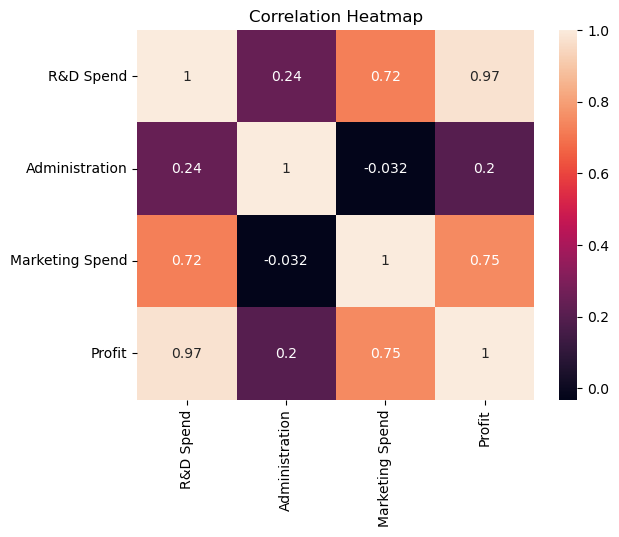

In [7]:
correlation = df.corr()
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.show()

It can be seen that "Marketing Spend" and "R&D Spend" has a moderately high correlation with each other.

**Checking for outliers**

In [8]:
def create_plots(df, x_col_boxplot, y_col_boxplot, x_col_scatter, y_col_scatter, title_boxplot, title_scatter):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Boxplot
    sns.boxplot(y=df[y_col_boxplot], x=df[x_col_boxplot], ax=axes[0])
    axes[0].set_title(title_boxplot)

    # Scatter plot with line of best fit
    sns.regplot(x=df[x_col_scatter], y=df[y_col_scatter], ax=axes[1])
    axes[1].set_title(title_scatter)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()

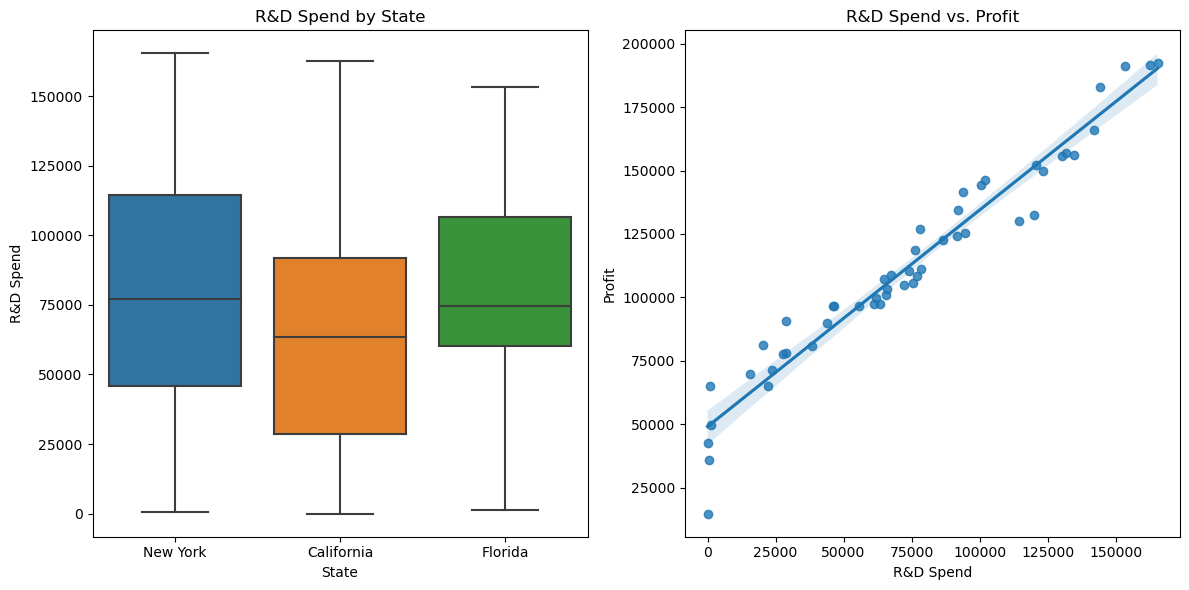

In [9]:
create_plots(df, "State", "R&D Spend", "R&D Spend", 'Profit', 'R&D Spend by State', 'R&D Spend vs. Profit' )

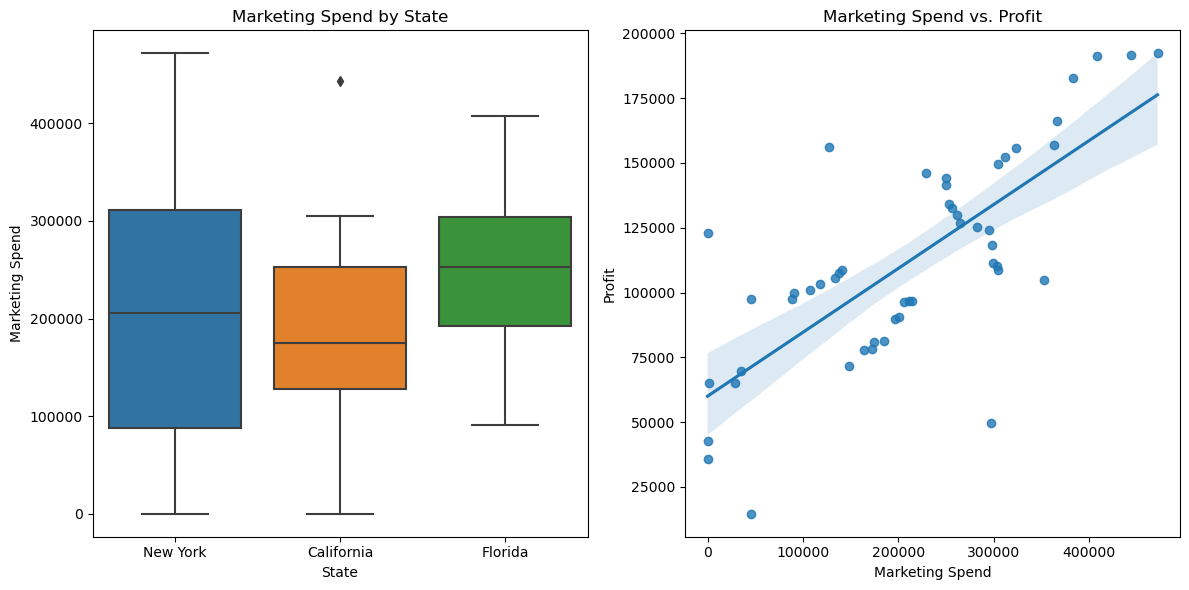

In [10]:
create_plots(df, "State",
             "Marketing Spend",
             "Marketing Spend",
             'Profit',
             'Marketing Spend by State',
             'Marketing Spend vs. Profit')

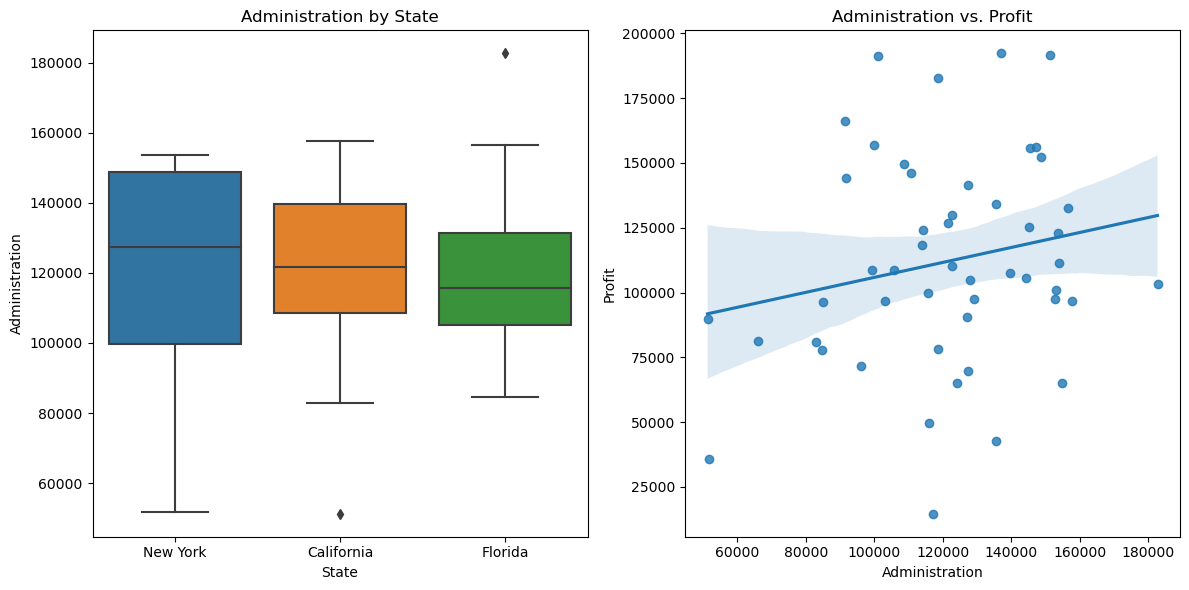

In [11]:
create_plots(df, "State",
             "Administration",
             "Administration",
             'Profit',
             'Administration by State',
             'Administration vs. Profit')

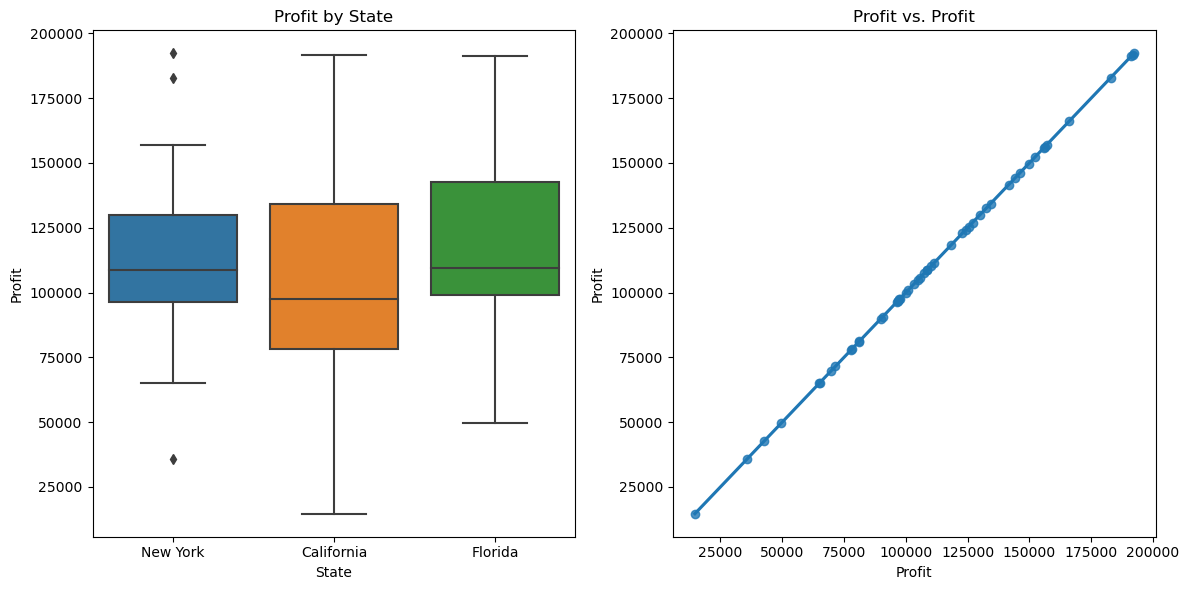

In [12]:
create_plots(df, "State",
             "Profit",
             "Profit",
             'Profit',
             'Profit by State',
             'Profit vs. Profit')

In [13]:
df.shape

(50, 5)

# Data Preparation

**Renaming Columns**

In [14]:
df.rename(columns = {'R&D Spend' : 'R&D_Spend', 'Marketing Spend' : 'Marketing_Spend'}, inplace = True)

In [15]:
df.head()

,R&D_Spend,Administration,Marketing_Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


**Removing Outliers**

For outliers we are only removing from Marketing Spend and Administration

In [16]:
cols_to_remove_outliers = ['Marketing_Spend', 'Administration']

for column in cols_to_remove_outliers:
    if column in df.columns:
        Q1 = df.groupby('State')[column].quantile(0.25)
        Q3 = df.groupby('State')[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_mask = df.groupby('State')[column].apply(lambda x: (x < lower_bound[x.name]) | (x > upper_bound[x.name]))
        df = df[~outlier_mask]
    else:
        print(f"Column '{column}' does not exist in the DataFrame.")

In [17]:
df.shape

(47, 5)

**Encode categorical columns**

In [18]:
# Instantiate OneHotEncoder

encoder = ce.OneHotEncoder(cols=['State'], use_cat_names = True)
df_encoded = encoder.fit_transform(df)
df_encoded.head()

,R&D_Spend,Administration,Marketing_Spend,State_New York,State_Florida,State_California,Profit
0,165349.20,136897.80,471784.10,1,0,0,192261.83
2,153441.51,101145.55,407934.54,0,1,0,191050.39
3,144372.41,118671.85,383199.62,1,0,0,182901.99
4,142107.34,91391.77,366168.42,0,1,0,166187.94
5,131876.90,99814.71,362861.36,1,0,0,156991.12


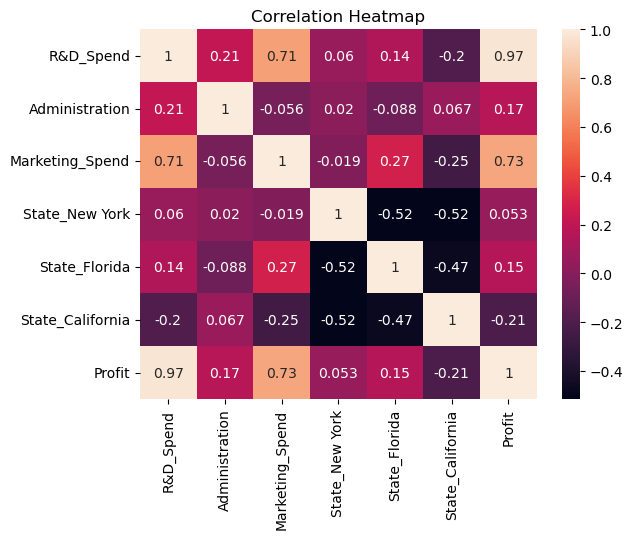

In [19]:
correlation_en = df_encoded.corr()
plt.title("Correlation Heatmap")
sns.heatmap(correlation_en, annot=True)
plt.show()

In [20]:
df_encoded.shape

(47, 7)

array([[<Axes: title={'center': 'R&D_Spend'}>,
        <Axes: title={'center': 'Administration'}>,
        <Axes: title={'center': 'Marketing_Spend'}>],
       [<Axes: title={'center': 'State_New York'}>,
        <Axes: title={'center': 'State_Florida'}>,
        <Axes: title={'center': 'State_California'}>],
       [<Axes: title={'center': 'Profit'}>, <Axes: >, <Axes: >]],
      dtype=object)

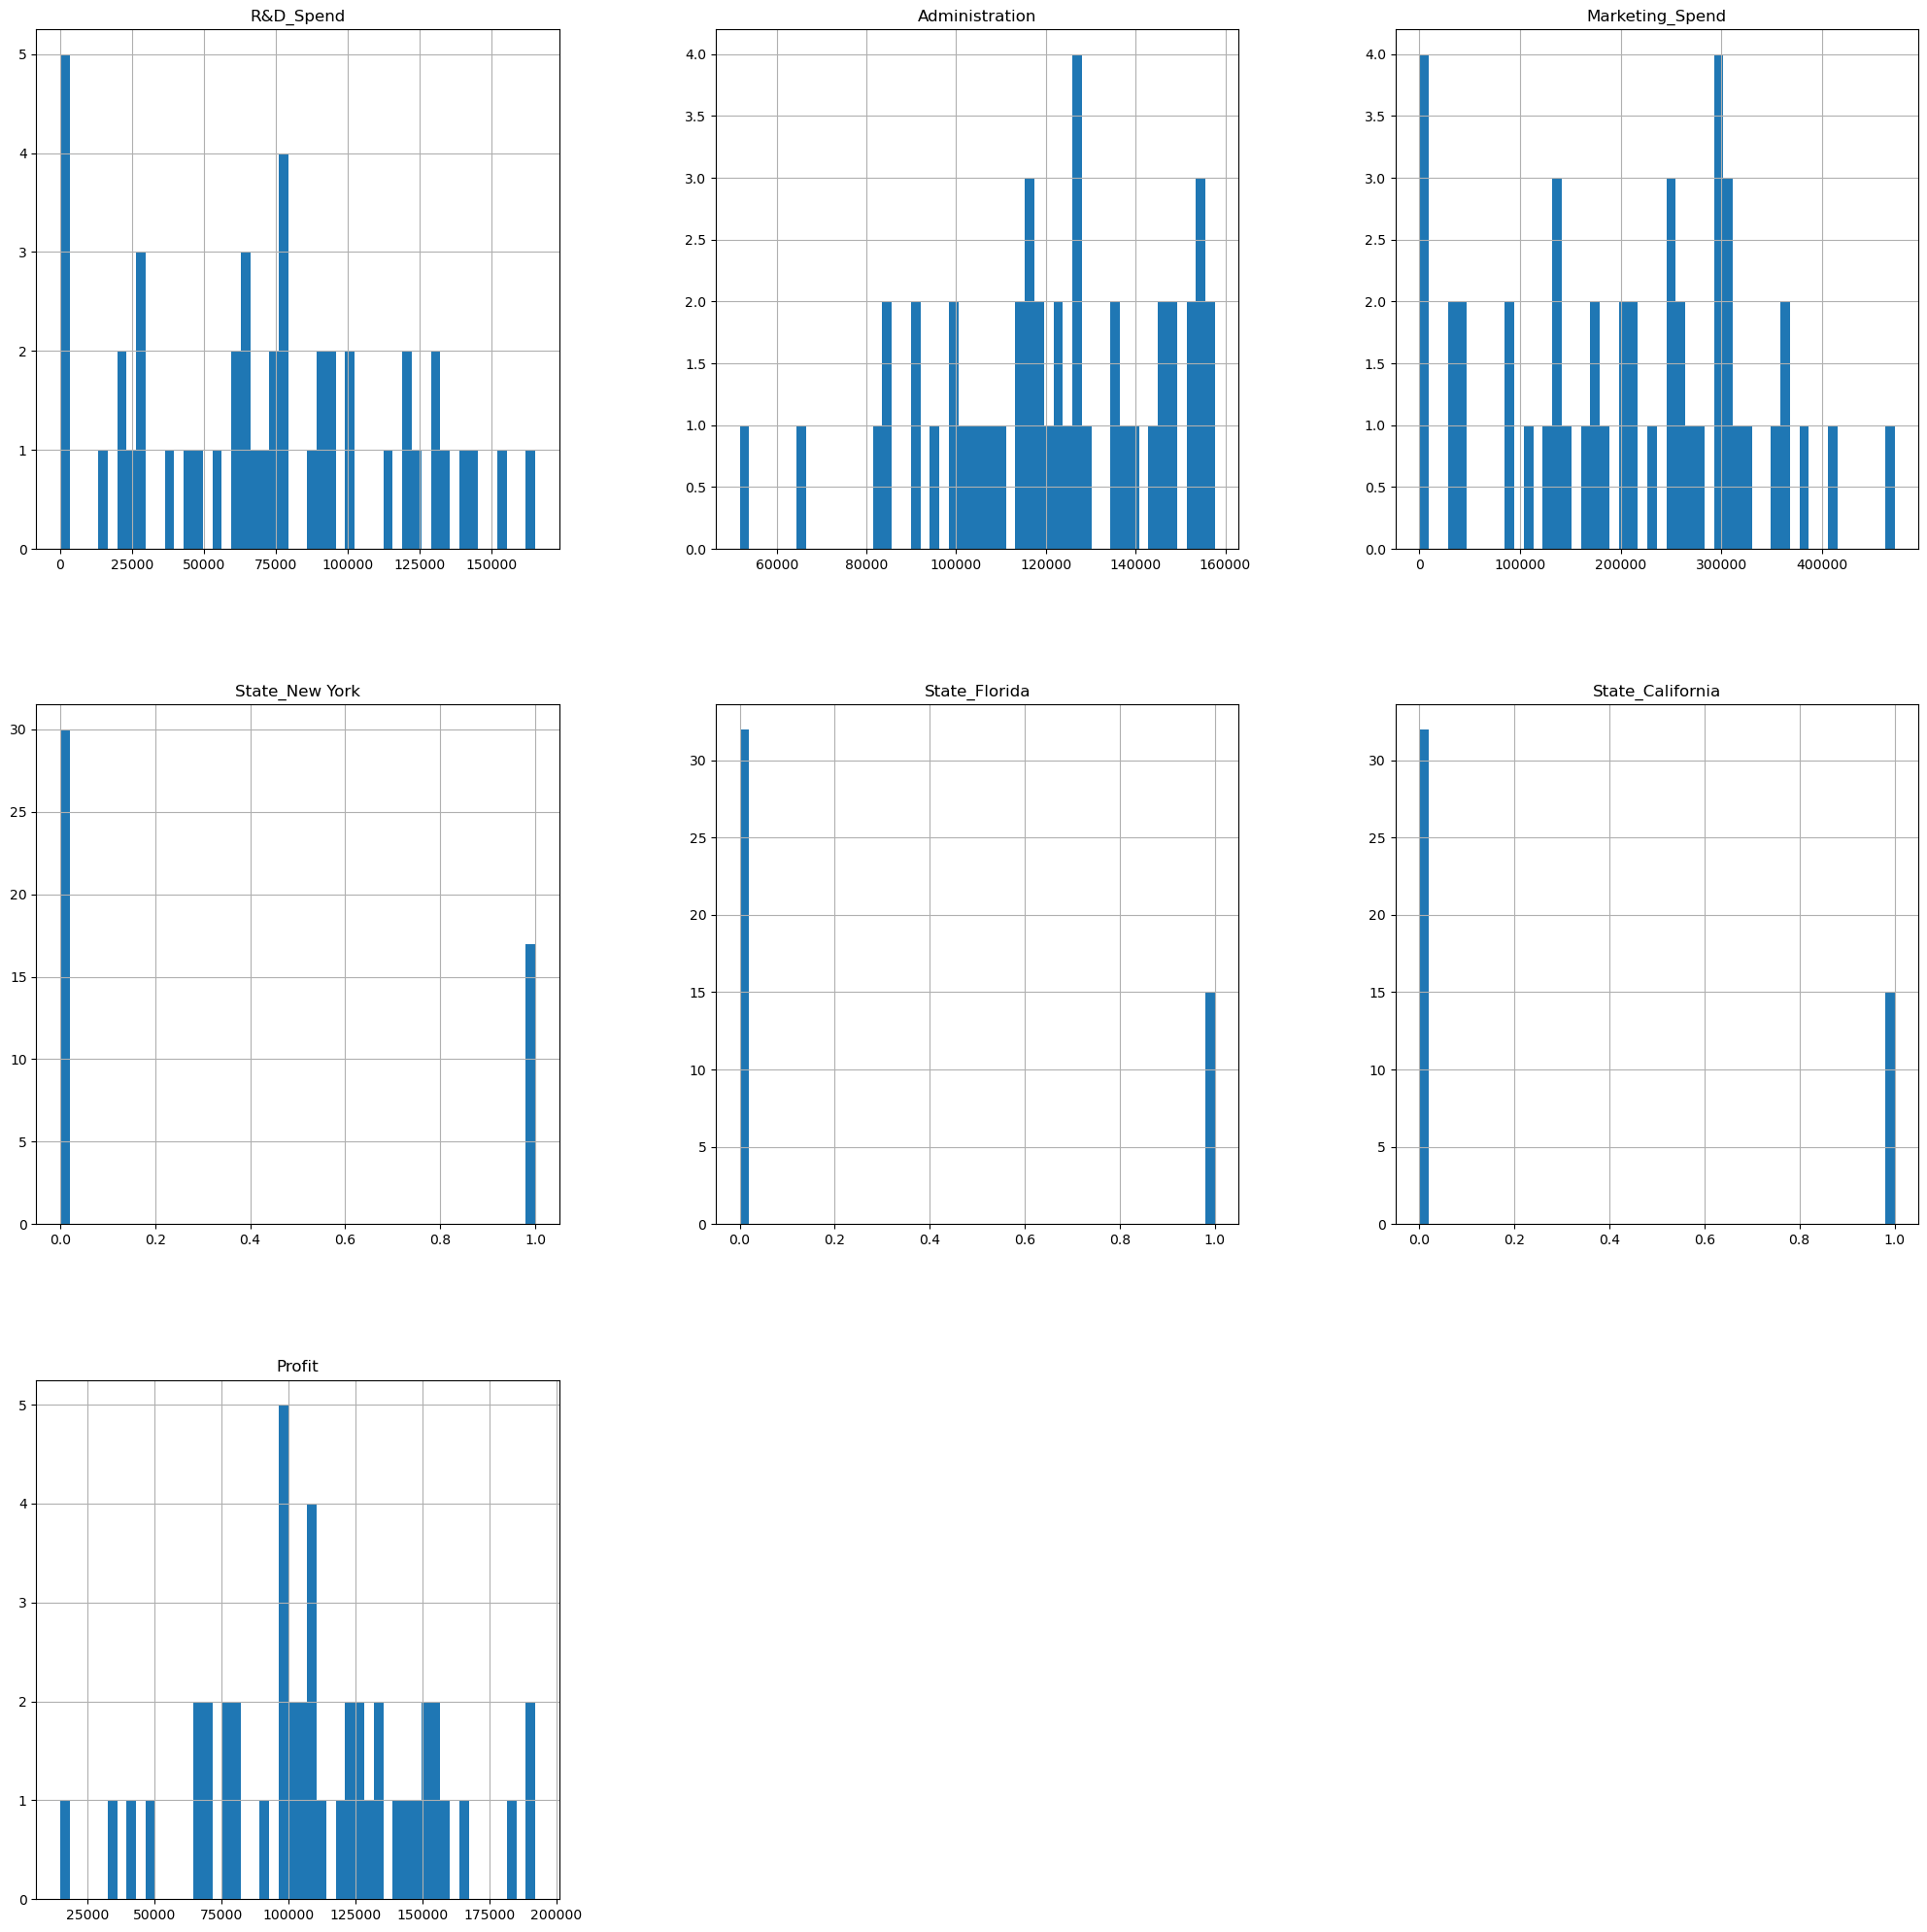

In [21]:
df_hist = df_encoded.select_dtypes(include=['float', 'int64', 'object'])
df_hist.hist(figsize=(25,25), bins = 50)

From what we can see in the above histograms is that the data is already distribited normally so normalizing and stadardizing is not necessary 

# **Seperating features and lables**

In [22]:
X = df_encoded.drop('Profit', axis=1)
y = df_encoded['Profit']

# Splitting data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Model Building

Comparing Linear regression model, Ridge regression model and Ridge regression model with hyperparameters 

### Linear regression

In [24]:
# Create the Linear Regression model
linear_model = LinearRegression(fit_intercept=True)

In [25]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = linear_model.predict(X_test)

In [27]:
linear_r_score = r2_score(y_test, y_pred)*100
linear_mae = round(mean_absolute_error(y_test, y_pred),2)
linear_mse = round(mean_squared_error(y_test, y_pred),2)
linear_rmse = round(np.sqrt(linear_mse),2)

**Linear Regression Model Evalution**

In [28]:
table_data = {
    'R score': [linear_r_score],
    'Mean Absolute Error': [linear_mae],
    'Mean Squared Error': [linear_mse],
    'Root Mean Squared Error': [linear_rmse],
    }
results_df = pd.DataFrame(table_data)
results_df.head()

,R score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,97.727961,4580.94,35962711.94,5996.89


Plot actual data vs prediction

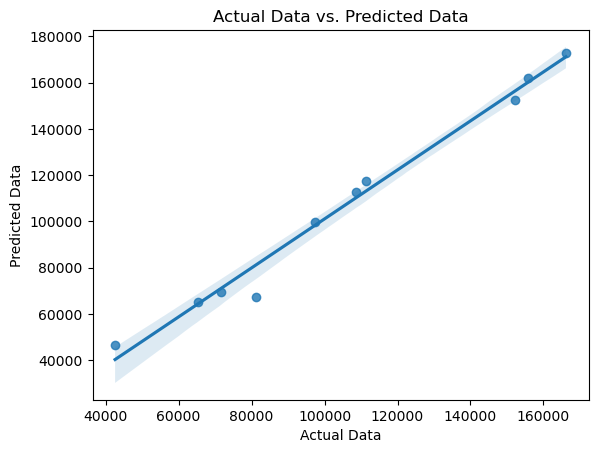

In [29]:
Linear_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  

# Create the regression plot
sns.regplot(data=Linear_data, x='Actual', y='Predicted')

# Set x-axis label
plt.xlabel('Actual Data')

# Set y-axis label
plt.ylabel('Predicted Data')

# Set plot title
plt.title('Actual Data vs. Predicted Data')

# Display the plot
plt.show()

### Ridge regression

In [30]:
rg = Ridge()

In [31]:
rg.fit(X_train, y_train)

Ridge()

In [32]:
y_pred = rg.predict(X_test)

In [33]:
rg_r_score = r2_score(y_test, y_pred)*100
rg_mae = round(mean_absolute_error(y_test, y_pred),2)
rg_mse = round(mean_squared_error(y_test, y_pred),2)
rg_rmse = round(np.sqrt(rg_mse),2)

**Ridge Model Evaluation (Untuned)**

In [34]:
table_data = {
    'R score': [rg_r_score],
    'Mean Absolute Error': [rg_mae],
    'Mean Squared Error': [rg_mse],
    'Root Mean Squared Error': [rg_rmse],
    }
results_df = pd.DataFrame(table_data)
results_df.head()

,R score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,97.741786,4575.66,35743882.12,5978.62


Plot actual data vs prediction

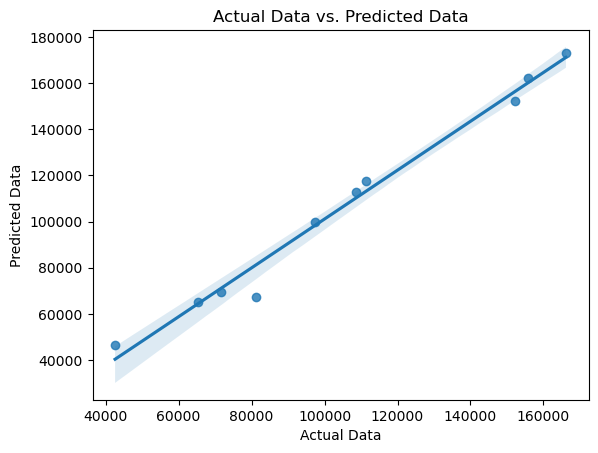

In [35]:
ridge_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  

# Create the regression plot
sns.regplot(data=ridge_data, x='Actual', y='Predicted')

# Set x-axis label
plt.xlabel('Actual Data')

# Set y-axis label
plt.ylabel('Predicted Data')

# Set plot title
plt.title('Actual Data vs. Predicted Data')

# Display the plot
plt.show()

### Tunning hyperparameters for Rige Model (Final Model)

In [36]:
param_grid = {'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
              'max_iter': [3,6,9,12,15],
              'tol': [1e-2,1e-3, 1e-4, 1e-5],
              'random_state': [42]}

In [37]:
grid_search = GridSearchCV(rg, param_grid, cv=5, verbose=2, n_jobs=-1)

In [38]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'max_iter': [3, 6, 9, 12, 15], 'random_state': [42],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             verbose=2)

In [39]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'fit_intercept': True, 'max_iter': 3, 'random_state': 42, 'solver': 'lsqr', 'tol': 0.01}


In [40]:
ridge = Ridge(**grid_search.best_params_)

In [41]:
ridge.fit(X_train, y_train)

Ridge(max_iter=3, random_state=42, solver='lsqr', tol=0.01)

In [42]:
ridge_y_pred = ridge.predict(X_test)

In [43]:
ridge_r_score = r2_score(y_test, ridge_y_pred)*100
ridge_mae = round(mean_absolute_error(y_test, ridge_y_pred),2)
ridge_mse = round(mean_squared_error(y_test, ridge_y_pred),2)
ridge_rmse = round(np.sqrt(ridge_mse),2)

**Tuned Ridge Model Evaluation**

In [44]:
table_data = {
    'R score': [ridge_r_score],
    'Mean Absolute Error': [ridge_mae],
    'Mean Aquared Error': [ridge_mse],
    'Root Mean Squared Error': [ridge_rmse],
    }
results_df = pd.DataFrame(table_data)
results_df.head()

,R score,Mean Absolute Error,Mean Aquared Error,Root Mean Squared Error
0,97.89227,4511.23,33361966.23,5775.98


As we can see the final model had a R^2 score of 97% which shows that the model is well suited for this data. When looking at the root mean squared error, we can also see that its quite good as the variance in the actual data is very large. Overall if the model is given more data, the performance will certainly improve as there are currently only 47 instances where only 37 of those instances could be trained on.

Plot actual data vs prediction

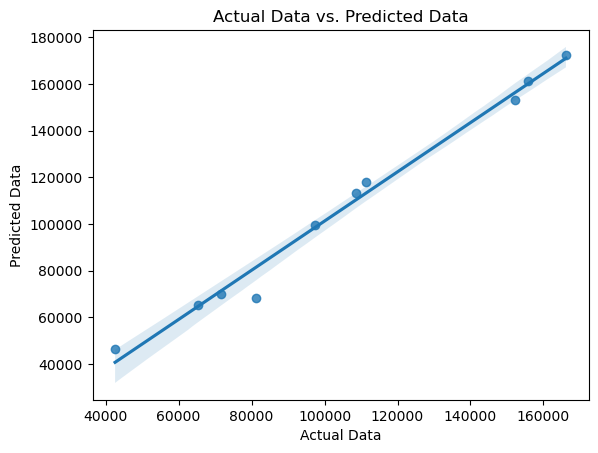

In [45]:
tuned_ridge_data = pd.DataFrame({'Actual': y_test, 'Predicted': ridge_y_pred})  

# Create the regression plot
sns.regplot(data=tuned_ridge_data, x='Actual', y='Predicted')

# Set x-axis label
plt.xlabel('Actual Data')

# Set y-axis label
plt.ylabel('Predicted Data')

# Set plot title
plt.title('Actual Data vs. Predicted Data')

# Display the plot
plt.show()

# Results Interpretation

Comparing metrics

In [46]:
table_data = {
    'Model': ['Linear', 'Ridge','Tuned Ridge'],
    'R score': [linear_r_score,rg_r_score, ridge_r_score],
    'Mean Absolute Error': [linear_mae,rg_mae,ridge_mae],
    'Mean Squared Error': [linear_mse,rg_mse,ridge_mse],
    'Root Mean SquaredError': [linear_rmse,rg_rmse,ridge_rmse]
   
    }


In [47]:
results_df = pd.DataFrame(table_data)
results_df.head()

,Model,R score,Mean Absolute Error,Mean Squared Error,Root Mean SquaredError
0,Linear,97.727961,4580.94,35962711.94,5996.89
1,Ridge,97.741786,4575.66,35743882.12,5978.62
2,Tuned Ridge,97.892270,4511.23,33361966.23,5775.98


Metrics used to evaluate models:

R-Squared (R2 Score): R2 score measures the proportion of the variance in the dependent variable that can be explained by the independent variables in a regression model. A higher R2 score indicates a better fit of the regression model to the data.

Mean Absolute Error (MAE): MAE represents the average absolute difference between the predicted values and the true values. Lower values of MAE indicate better model performance.

Mean Squared Error (MSE): MSE calculates the average squared difference between the predicted values and the true values. Similar to MAE, lower values of MSE indicate better model performance.

Root Mean Squared Error (RMSE): RMSE is the square root of the MSE, which returns the metric in the same units as the target variable. Similar to MAE and MSE, lower values of RMSE indicate better model performance.




Evaluation :

The Ridge model had better scores in all metrics compared to the Linear regression model, and after tuning the Ridge model's hyperparameter, the tuned model had better scores in all metric compared to the standard Ridge model.

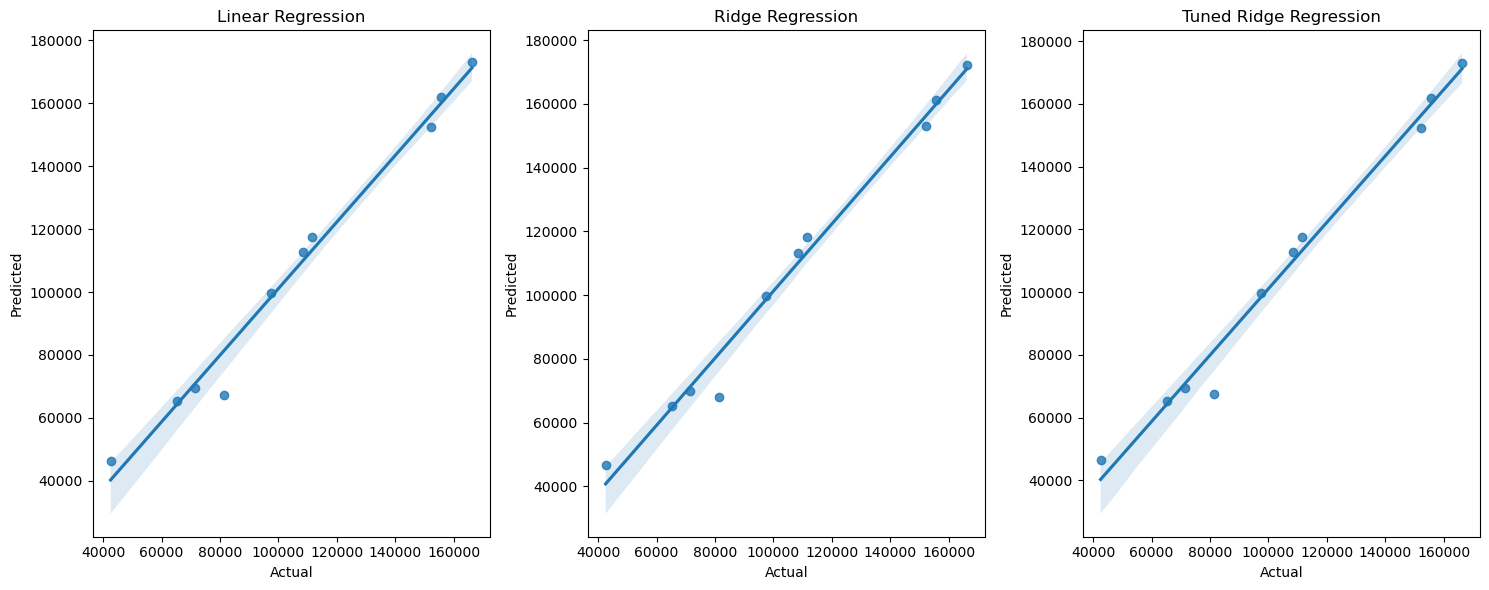

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Plot the first regression plot on the first subplot
sns.regplot(data=Linear_data, x='Actual', y='Predicted', ax=axes[0])
axes[0].set_title('Linear Regression')

# Plot the second regression plot on the second subplot
sns.regplot(data=tuned_ridge_data, x='Actual', y='Predicted', ax=axes[1])
axes[1].set_title('Ridge Regression')

# Plot the third regression plot on the third subplot
sns.regplot(data=ridge_data, x='Actual', y='Predicted', ax=axes[2])
axes[2].set_title('Tuned Ridge Regression')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Comparing the 3 models on graphs we see they are very simular except for the slightest changes in the gradients.

In exploring we noticed:


Correlation:
That the administration column has a very low correlation with the target column compared to R&D spend and Marketing Spend and that Marketing Spend and R&D Spend have a moderately high correlation with each other.

Outliers:
We noticed outliers in Marketing spend by state, Administration by state and Profit by state using boxplots. Removing the outliers for Marketing spend and Administration increased performance but removing outlier for profits decreased performance. Removing only Marketing spend or Administration also decreased performance.

We also noticed that by looking at the gradients of the slope of scatter plots for Marketing spend vs profit, R&D spend vs profit and Administration vs profit, that Market spend and R&D spend are highly related to profit with a increase in those features having a high chance of increasing profit. While Administartation has little effect on the profit.
